In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF
from gpzoo.gp import SVGP
from gpzoo.likelihoods import Hybrid_NSF
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
new_model=False

In [4]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: >

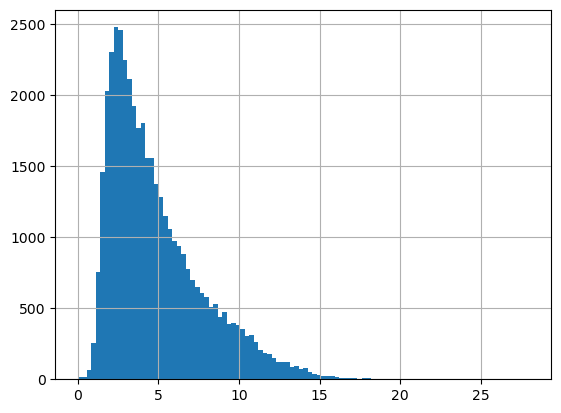

In [7]:
adata.obs.pct_counts_mt.hist(bins=100)

In [8]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K

In [9]:
sc.pp.filter_cells(adata, min_counts=100)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [10]:
sc.pp.filter_genes(adata, min_cells=1)

In [11]:
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx]

In [12]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [13]:
# Y_sums = np.array(np.sum(adata.X > 0, axis=0))[0]

# Y_nsf = np.array(adata.X[:, Y_sums>100].todense() * 100, dtype=int).T
# Y = np.array(adata.X[:].todense()*100, dtype=int).T

In [14]:
Y = Dtr['Y'].T

In [15]:
X = Dtr['X']*50.0

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:26: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


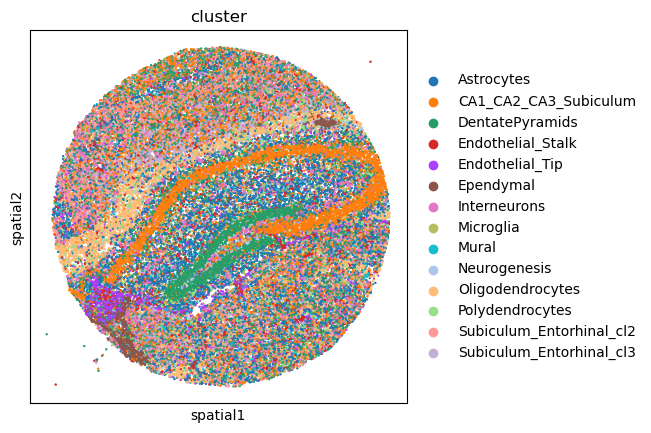

In [16]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None)

# plt.figure(figsize=(10, 10))
# for i, category in enumerate(adata.obs.cluster.values.categories):
#     mask = adata.obs.cluster.values==category
#     plt.subplot(4, 4, i+1)
#     plt.title(category, fontsize=8)
#     plt.scatter(adata.obs.x[mask], adata.obs.y[mask], alpha=0.1, s=2)
#     plt.xlim([0, 6000])
#     plt.ylim([0, 6000])
#     plt.gca().invert_yaxis()
#     plt.xticks([])
#     plt.yticks([])

In [17]:
factors, loadings = regularized_nmf(Y.T, L=20, shrinkage=0.3, max_iter = 20, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=7)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [18]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

In [19]:
factors_ordered = factors[:, moran_idx]
loadings_ordered = loadings[:, moran_idx]

In [20]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [21]:
L =10
M = 3000



idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)


kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=1.8)
gp = SVGP(kernel, M=M, jitter=1e-1)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M))
# gp.mu = nn.Parameter(5e-1*torch.randn((L, M)))
gp.mu = nn.Parameter(torch.tensor(factors_ordered[idx][:, :L], dtype=torch.float).T)
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)



model = Hybrid_NSF(gp=gp, y=Y, L=L, non_spatial_factors=L)
model.mF = nn.Parameter(torch.tensor(factors_ordered[:, L:], dtype=torch.float).T)
model.W = nn.Parameter(torch.tensor(loadings_ordered[:, :L], dtype=torch.float))
# model.W2 = nn.Parameter(torch.tensor(loadings_ordered[:, L:], dtype=torch.float))
# model.gp.precompute_distance(X, idx)



# if not new_model:
    
#     model.load_state_dict(torch.load('slideseq_nsf', map_location=device))
#     print('Model loaded')
    
model.to(device)

/tmp/ipykernel_4040383/1378158977.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


Hybrid_NSF(
  (gp): SVGP(
    (kernel): NSF_RBF()
  )
)

In [22]:
model.gp.Lu.requires_grad = True
model.gp.mu.requires_grad = True
model.W.requires_grad=False
model.gp.kernel.lengthscale.requires_grad = True
model.gp.kernel.sigma.requires_grad = False
model.gp.Z.requires_grad=False

In [23]:
X_train = X.to(device)
Y_train = Y.to(device)

In [24]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [25]:
# model.gp.jitter=5e-2

In [36]:
model.to(device)
losses = train_hybrid_batched(model, optimizer, X_train, Y_train, device, steps=2000, E=10, batch_size=3200)
# losses = train_hybrid(model, optimizer, X_train, Y_train, device, steps=1500*8, E=10)


  0%|          | 0/500 [00:00<?, ?it/s]

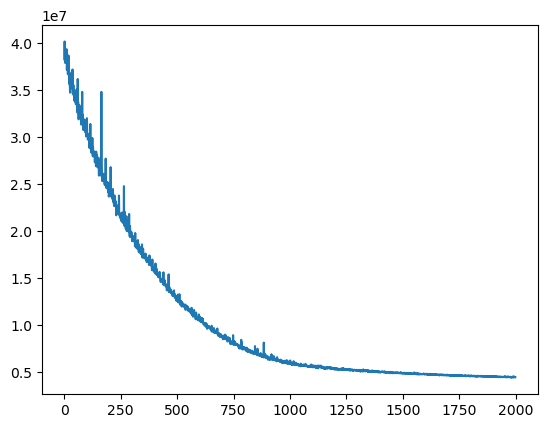

In [37]:
plt.plot(losses)

In [ ]:
model.cpu()

# idz = torch.multinomial(torch.ones(len(X)), num_samples=30000, replacement=False)

qF, qU, pU = model.gp(X)

factors = torch.exp(qF.mean).detach().cpu().numpy()
factors2 = torch.exp(model.mF).detach().cpu().numpy()
factors_scales = qF.scale.detach().cpu().numpy()


del qF, qU, pU
with torch.no_grad():
    if device.type=='cuda':
        torch.cuda.empty_cache()

In [ ]:
factors.max()

In [ ]:
max_val = np.percentile(factors, 99)
min_val = np.percentile(factors, 1)


size = 7
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=0.9, cmap='turbo')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_facecolor('xkcd:gray')


In [ ]:
max_val = np.percentile(factors2, 95)
min_val = np.percentile(factors2, 5)


size = 7
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[:, 0], X[:,1], c=factors2[i], vmin=min_val, vmax=max_val, alpha=0.9, cmap='turbo')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_facecolor('xkcd:gray')

In [ ]:
max_val = np.percentile(factors_scales, 95)
min_val = np.percentile(factors_scales, 5)


size = 7
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[:, 0], X[:,1], c=factors_scales[i], vmin=min_val, vmax=max_val, alpha=0.9,cmap='turbo')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_facecolor('xkcd:gray')

In [ ]:
model.gp.kernel.lengthscale 

In [ ]:
model.W

In [ ]:
loadings[:, moran_idx]

In [ ]:
model.W2